<a href="https://colab.research.google.com/github/RachmadAgungP/Data/blob/master/penjelasan_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class LSTM

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LSTMCell: 
    # numCells = ukuran penampungan I,o,z,dll
    # Size is the dimensionality of the input vector
    def __init__(self, inputSize, numCells, W):
        self.inputSize = inputSize
        self.numCells = numCells

        # Randomly initialise the weight matrix
        # self.W = np.random.random((4 * numCells, inputSize + numCells)) * 2 \
        #                 - np.ones((4 * numCells, inputSize + numCells))
        
        self.W = W
        
        W = pd.DataFrame(self.W)
        #bobot disimpan .csv
        W.to_csv("P_W.csv",header=False,index=False) 
        #pemanggilan .csv
        # weight = pd.read_csv('P_W.csv')
        # weight = weight.values.tolist()
        # weighting = np.array(weight)
        # self.W = weighting
                    
        self.h = []
        self.C = []
        self.C_bar = []
        self.i = []
        self.f = []
        self.o = []

        self.I = []
        self.z = []

    # x is the input vector (including bias term), returns output h
    def forwardStep(self, x):
       
        I = np.concatenate((x, self.h[-1])) #mengabungkan
        self.I.append(I) 
        z = np.dot(self.W, I)
        self.z.append(z)
        # Compute the candidate value vector
        C_bar = np.tanh(z[0:self.numCells])
        self.C_bar.append(C_bar)
        # Compute input gate vector
        i = sigmoid(z[self.numCells:self.numCells * 2])
        self.i.append(i)
        # Compute forget gate vector
        f = sigmoid(z[self.numCells * 2:self.numCells * 3])
        self.f.append(f)
        # Compute the output gate vector
        o = sigmoid(z[self.numCells * 3:])
        self.o.append(o)
        # Compute the new state vector as the elements of the old state allowed
        # through by the forget gate, plus the candidate values allowed through
        # by the input gate
        C = np.multiply(f, self.C[-1]) + np.multiply(i, C_bar)
        self.C.append(C)
        # Compute the new output
        h = np.multiply(o, np.tanh(C))
        self.h.append(h)
        
        return (h,C,o,f,i,C_bar,z,I,self.W)
    # x = trainingSequences (data training)
    def forwardPass(self, x):
        
        self.h = []
        self.C = []
        self.C_bar = []
        self.i = []
        self.f = []
        self.o = []

        self.I = []
        self.z = []
        
        numCells = self.numCells 
        
        self.h.append(np.zeros(numCells)) # initial output is empty
        
        self.C.append(np.zeros(numCells)) # initial state is empty
        
        self.C_bar.append(np.zeros(numCells)) # this and the following
        
        # empty arrays make the indexing follow the indexing in papers
        self.i.append(np.zeros(numCells)) 
        self.f.append(np.zeros(numCells)) 
        self.o.append(np.zeros(numCells)) 
        self.I.append(np.zeros(numCells)) 
        self.z.append(np.zeros(numCells)) 
    
        O_W= []
        O_I= []
        O_z= []
        O_c= []
        O_o= []
        O_f= []
        O_in= []
        O_c_bar= []
        O_h = []
        
        for x_t in x:
            w = self.forwardStep(x_t)
            O_W.append(w[8])    
            O_I.append(w[7])    
            O_z.append(w[6])    
            O_c.append(w[1])    
            O_o.append(w[2])    
            O_f.append(w[3])    
            O_in.append(w[4])   
            O_c_bar.append(w[5])
            O_h.append(w[0])    
        
        # print(O_h)
        return (O_I,O_z,O_c,O_o,O_f,O_in,O_c_bar,O_h,O_W)

    def backwardStep(self, t, dE_dh_t, dE_dc_tplus1):
        dE_do_t = np.multiply(dE_dh_t, np.tanh(self.C[t]))
        #print("-----------------------------------------")
        dE_dc_t = dE_dc_tplus1 + np.multiply(np.multiply(dE_dh_t, self.o[t]), (np.ones(self.numCells) - np.square(np.tanh(self.C[t]))))
        dE_di_t = np.multiply(dE_dc_t, self.C_bar[t])
        dE_dcbar_t = np.multiply(dE_dc_t, self.i[t])
        dE_df_t = np.multiply(dE_dc_t, self.C[t - 1])
        dE_dc_tminus1 = np.multiply(dE_dc_t, self.f[t])
        
        dE_dzcbar_t = np.multiply(dE_dcbar_t, (np.ones(self.numCells) - np.square(np.tanh(self.z[t][0:self.numCells]))))
        dE_dzi_t = np.multiply(np.multiply(dE_di_t, self.i[t]), (np.ones(self.numCells) - self.i[t]))
        dE_dzf_t = np.multiply(np.multiply(dE_df_t, self.f[t]), (np.ones(self.numCells) - self.f[t]))
        dE_dzo_t = np.multiply(np.multiply(dE_do_t, self.o[t]), (np.ones(self.numCells) - self.o[t]))
        dE_dz_t = np.concatenate((dE_dzcbar_t, dE_dzi_t, dE_dzf_t, dE_dzo_t))
        dE_dI_t = np.dot(np.transpose(self.W), dE_dz_t)
        dE_dh_tminus1 = dE_dI_t[self.inputSize:]
        dE_dz_t.shape = (len(dE_dz_t), 1)
        self.I[t].shape = (len(self.I[t]), 1)
        dE_dW_t = np.dot(dE_dz_t, np.transpose(self.I[t])) # this one is confusing cos it says X_t instead of I_t, but there is no matrix or vector X,
        # and the matrix dimensions are correct if we use I instead
        # r = pd.DataFrame(dE_dW_t)
        # r.to_csv('dE_dW_t%s.csv'%t)
        return (dE_dW_t, dE_dh_tminus1, dE_dc_tminus1, dE_do_t, dE_dc_t, dE_di_t, dE_dcbar_t,dE_df_t,dE_dzcbar_t,dE_dzi_t,dE_dzf_t,dE_dzo_t,dE_dz_t,dE_dI_t)
    # Back propagation through time, returns the error and the gradient for this sequence
    # (should I give this the sequence x1,x2,... so that this method is tied
    # to the sequence?)
    def BPTT(self, y):
        numTimePeriods = len(y)
        dE_dW = 0 
        dE_dh_t = 0
        dE_dc_t = 0
        E = 0.0
        discount = 1.0
        dE_dW_t_list= []
        dE_dh_tminus1_list= []
        dE_dc_tminus1_list= []
        dE_do_t_list= []
        dE_dc_t_list= []
        dE_di_t_list= []
        dE_dcbar_t_list= []
        dE_df_t_list= []
        dE_dzcbar_t_list= []
        dE_dzi_t_list= []
        dE_dzf_t_list= []
        dE_dzo_t_list= []
        dE_dz_t_list= []
        dE_dI_t_list= []

        dE_dh_tplus1_list= []
        dE_dc_tplus1_list= []

        dE_dW_list = []
        error_list = []  
        for i in range(numTimePeriods):
            index = numTimePeriods - i
            E = E + 0.5 * np.sum(np.absolute(self.h[index] - y[index - 1])) # This is the error/loss vector for this sequence
            error_list.append(E)
            # The gradient is just 1 or -1, depending on whether h is
            # less than or greater than y
            lessThan = np.less(self.h[index], y[index - 1])
            greaterThan = np.greater(self.h[index], y[index - 1])
            dE_dh_t -= 0.5 * lessThan
            dE_dh_t += 0.5 * greaterThan
            dE_dh_tplus1_list.append(dE_dh_t)
            dE_dc_tplus1_list.append(dE_dc_t)
            #dE_dh_t += self.h[index] - y[index - 1] # This is the error gradient for this sequence
            result = self.backwardStep(index, dE_dh_t, dE_dc_t) 
            dE_dW = dE_dW + result[0] # dE_dW_t
            dE_dW_list.append(dE_dW)

            dE_dh_t = result[1]
            dE_dc_t = result[2]

            dE_dW_t_list.append(result[0])
            dE_dh_tminus1_list.append(dE_dh_t)
            dE_dc_tminus1_list.append(dE_dc_t)
            dE_do_t_list.append(result[3])
            dE_dc_t_list.append(result[4])
            dE_di_t_list.append(result[5])
            dE_dcbar_t_list.append(result[6])
            dE_df_t_list.append(result[7])
            dE_dzcbar_t_list.append(result[8])
            dE_dzi_t_list.append(result[9])
            dE_dzf_t_list.append(result[10])
            dE_dzo_t_list.append(result[11])
            dE_dz_t_list.append(result[12])
            dE_dI_t_list.append(result[13])
            # discount *= 0.99
            
        return (E / (numTimePeriods), dE_dW, dE_dW_t_list, dE_dh_tminus1_list, dE_dc_tminus1_list, dE_do_t_list, dE_dc_t_list, dE_di_t_list, dE_dcbar_t_list, dE_df_t_list, dE_dzcbar_t_list, dE_dzi_t_list, dE_dzf_t_list, dE_dzo_t_list, dE_dz_t_list, dE_dI_t_list, dE_dh_tplus1_list, dE_dc_tplus1_list, dE_dW_list)
    def forecast(self,forecastingData):
        forward = self.forwardPass(forecastingData)
        f_l = np.transpose(np.transpose(forward[0]))
        f_z = np.transpose(np.transpose(forward[1]))
        f_c = np.transpose(np.transpose(forward[2]))
        f_o = np.transpose(np.transpose(forward[3]))
        f_f = np.transpose(np.transpose(forward[4]))
        f_i = np.transpose(np.transpose(forward[5]))
        f_c_bar = np.transpose(np.transpose(forward[6]))
        f_h = np.transpose(np.transpose(forward[7]))
        f_W = np.transpose(np.transpose(forward[8]))
        return (f_h[-1],f_l,f_z,f_c,f_o,f_f,f_i,f_c_bar,f_h,f_W)

# Fungsi - fungsi 

## FUNGSI Menampilkan hitungan manual

In [0]:
def view_hitung_manual(jenis_proses,data_t,kon):
    if jenis_proses == "forward":
        print ("PROSES FORWARD")
        if (kon == "I" or kon == "Z" or kon == "W"):
            view = pd.DataFrame(data=data_t[kon].tolist(),columns=["C","i","f","o"]).T
            return(view)
        else:
            view = pd.DataFrame(data=data_t[kon].tolist(),columns=[i]).T
            return(view)
    elif jenis_proses == "backward":
        print ("PROSES BACKWARD")
        if kon == "dE_dW_t" or kon == "dE_dW_list":
            view = pd.DataFrame(data=data_t[kon].tolist(),columns=["C","i","f","o"]).T
            return(view)
        elif kon == "dE_dz_t":
            view = pd.DataFrame(data=data_t[kon].tolist(),columns=["dE_dzcbar_t", "dE_dzi_t", "dE_dzf_t", "dE_dzo_t"]).T
            return(view)
        elif kon == "dE_dI_t":
            view = pd.DataFrame(data=data_t[kon].tolist(),columns=["bias", "date", "x(close)", "h(Close)"]).T
            return(view)
        else:
            view = pd.DataFrame(data=data_t[kon].tolist(),columns=[kon]).T
            return(view)
    else:
        view = pd.DataFrame(data=data_t[kon].tolist(),columns=[kon]).T
        return(view)


In [0]:
def tampung_hitung_manual(jenis_proses,data):
    if jenis_proses == "forward": 
        var_hidden_layer = data
        list_table_hitung_str = ["I","Z","C","O","F","I_in","C_bar","h","W"]
    elif jenis_proses == "backward":
        var_hidden_layer = data
        list_table_hitung_str = ["dE_dW_t", "dE_dh_tminus1", "dE_dc_tminus1", "dE_do_t", "dE_dc_t", "dE_di_t", "dE_dcbar_t", "dE_df_t","dE_dzcbar_t","dE_dzi_t","dE_dzf_t","dE_dzo_t","dE_dz_t","dE_dI_t", "dE_dh_tplus1", "dE_dc_tplus1","dE_dW"]
    else:
        var_hidden_layer = data
        list_table_hitung_str = ["W"]

    data_full = {}
    data_perhitungan = pd.DataFrame(data_full) 
    vel_hidden_layer = []
    count = 0
    for i in var_hidden_layer:
        data_perhitungan.insert(count, list_table_hitung_str[count],np.transpose(np.transpose(i)).tolist(), True) 
        count += 1
    return data_perhitungan

## FUNGSI Generator untuk memotong data sesuai squencial 

In [0]:
import random
def sequenceProducer(trainingData, sequenceLength):
    indices = [i for i in range(0, trainingData.shape[0] - sequenceLength + 1, sequenceLength)]
    #random.shuffle(indices)
    for index in indices:
        yield trainingData[index:index + sequenceLength]

In [0]:
import numpy as np
a = []
for r in range(1,100):
    a.append([])
    a[r-1].append(r)
c = np.array(a)
b = sequenceProducer(c, 5)
for t in range(1,20):
  print (next(b))

[[1]
 [2]
 [3]
 [4]
 [5]]
[[ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
[[11]
 [12]
 [13]
 [14]
 [15]]
[[16]
 [17]
 [18]
 [19]
 [20]]
[[21]
 [22]
 [23]
 [24]
 [25]]
[[26]
 [27]
 [28]
 [29]
 [30]]
[[31]
 [32]
 [33]
 [34]
 [35]]
[[36]
 [37]
 [38]
 [39]
 [40]]
[[41]
 [42]
 [43]
 [44]
 [45]]
[[46]
 [47]
 [48]
 [49]
 [50]]
[[51]
 [52]
 [53]
 [54]
 [55]]
[[56]
 [57]
 [58]
 [59]
 [60]]
[[61]
 [62]
 [63]
 [64]
 [65]]
[[66]
 [67]
 [68]
 [69]
 [70]]
[[71]
 [72]
 [73]
 [74]
 [75]]
[[76]
 [77]
 [78]
 [79]
 [80]]
[[81]
 [82]
 [83]
 [84]
 [85]]
[[86]
 [87]
 [88]
 [89]
 [90]]
[[91]
 [92]
 [93]
 [94]
 [95]]


In [0]:
def forecastSequenceProducer(trainingData, sequenceLength):
    for i in range(trainingData.shape[0] - sequenceLength + 1):
        yield trainingData[i:i + sequenceLength]

c = []
for r in range(1,100):
    c.append(r)

d = forecastSequenceProducer(c, 5)
for t in range(1,20):
    print (next(d))

## FUNGSI readdata

In [0]:
import numpy as np
import io
import requests


def readData(filename):
    data = pd.read_csv(io.StringIO(filename.decode('utf-8')))

    data = data[['Date','Close']]
    data['Date'] = pd.to_datetime(data['Date'])

    data1 = data[['Date','Close']]
    data1['Date'] = pd.to_datetime(data['Date'])
    s1 = data1.values.tolist()
    # data1.insert(0, "subject_index",0) 
    # ex_csv1 = pd.DataFrame(data1)
    # ex_csv1.to_csv("SMGRW.csv")

    data['Date'] =  data['Date'].dt.strftime("%Y%m%d").astype(int)

    s = data.values.tolist()
    training_data  = np.array(s)

    min_ex = np.amin(training_data, axis=0)
    max_ex = np.amax(training_data, axis=0)
    original_data = np.copy(training_data)
    training_data -= min_ex
    training_data /= max_ex
    tbl_data = pd.DataFrame(data=training_data,columns=["date","x(close)"])
    min_data = pd.DataFrame(data=min_ex,columns=[0]).T
    max_data = pd.DataFrame(data=max_ex,columns=[1]).T
    frame = [min_data,max_data]
    tbl_min_max = pd.concat(frame)
    tbl_min_max = tbl_min_max.rename(columns={0:"data",1:"x(close)"},index={0:"max",1:"min"})
    return (training_data, max_ex, min_ex, original_data,tbl_data,tbl_min_max)
    
def bagi_data(skenario,data_sa):
    if (skenario == 1):
        trainingData = data_sa[:-250]
        forecastData = data_sa[250:500]
    elif (skenario == 2):
        trainingData = data_sa[:-500]
        forecastData = data_sa[500:1000]
    elif (skenario == 5):
        trainingData = data_sa[:7]
        forecastData = data_sa[5:10]
    else :
        trainingData = data_sa[:-1000]
        forecastData = data_sa[500:-500]
    return (trainingData, forecastData)



# Membaca data




In [0]:
import pandas as pd
DataSahamStr = 'ujicoba.csv'
url_data = "https://raw.githubusercontent.com/RachmadAgungP/Data/master/ujicoba.csv" 
data = requests.get(url_data).content

data = readData(data)
tbl_data = data[4]
tbl_min_max = data[5]

print ("- tabel data normalisasi -")
print (tbl_data)
print ()
print ("-- tabel data min max --")
print (tbl_min_max)



- tabel data normalisasi -
           date  x(close)
0  0.000000e+00  0.030303
1  4.965213e-08  0.020202
2  1.986085e-07  0.026263
3  2.979128e-07  0.018182
4  3.475649e-07  0.000000
5  3.972170e-07  0.016162
6  5.461734e-07  0.026263
7  5.958256e-07  0.022222
8  6.454777e-07  0.024242
9  6.951298e-07  0.000000

-- tabel data min max --
           data  x(close)
max  20140109.0   12000.0
min  20140123.0   12375.0


# Inisial variable untuk input LSTM

In [0]:
# I_SequenceLength = int(input("masukkan panjang memory: "))
I_SequenceLength = 5
print ("Panjang memory(sequenceLength) adalah %s" %I_SequenceLength)
sequenceLength = I_SequenceLength

# numEpochs = int(input("masukkan banyak epoch : "))
numEpochs = 1
print ("banyak epoch adalah %s" %numEpochs)

data_saham_Normalisasi = data[0]

# rate = float(input("masukkan learning rate : "))
rate = 0.1
print ("Learnig rate adalah %s" %rate)

Panjang memory(sequenceLength) adalah 5
banyak epoch adalah 1
Learnig rate adalah 0.1


# Persiapan Data 

In [0]:
import numpy as np
# menambhakan data 1 atau bias 
data_saham_Normalisasi = np.concatenate((np.ones((data_saham_Normalisasi.shape[0], 1)), data_saham_Normalisasi), axis=1)


In [0]:
# skenarioI = int(input("masukkan skenario pilihan : "))
skenarioI = 5

# sebelum digabungkan 1 = [0.00000000e+00 4.32551320e-01]
import numpy as np
# setelah digabungkan 1 = [1.00000000e+00 0.00000000e+00 4.32551320e-01]
# pembagian skenario
skenarioP = bagi_data(skenarioI,data_saham_Normalisasi)
print ("banyak data training : ",len(skenarioP[0]))
training_Data = skenarioP[0]
tbl_data_training = pd.DataFrame(data=training_Data,columns=["bias","date","x(close)"])
print (tbl_data_training)
print (data_saham_Normalisasi.shape[0])
print ("banyak data testing : ",len(skenarioP[1]))
testing_Data = skenarioP[1]

banyak data training :  7
   bias          date  x(close)
0   1.0  0.000000e+00  0.030303
1   1.0  4.965213e-08  0.020202
2   1.0  1.986085e-07  0.026263
3   1.0  2.979128e-07  0.018182
4   1.0  3.475649e-07  0.000000
5   1.0  3.972170e-07  0.016162
6   1.0  5.461734e-07  0.026263
10
banyak data testing :  5


## CALL LSTM

In [0]:
lstm = LSTMCell(inputSize, numCells,W)

# LSTM

In [0]:
inputSize = data_saham_Normalisasi.shape[1]
numCells = data_saham_Normalisasi.shape[1]-2
W = [[-0.245714286	,0.850360602	,0.029262045	,0.184398087]
        ,[0.868020398	,0.860429754	,-0.379580925	,0.079506914]
        ,[-0.206444161	,-0.24856166	,-0.085253247	,0.25112624	]
        ,[0.842874383	,-0.324206065	,0.907722829	,-0.593738792]]

mtrx_w = pd.DataFrame(data=W,index=["C","i","f","o"], columns=["bias","date","x(close)","h(close)"])

print ("Ukuran Input ",inputSize)
print ("Ukuran Output ",numCells)
print ("Ukuran bobot ",len(W))
print ("-------------- matriks bobot ------------")
print (mtrx_w)

Ukuran Input  3
Ukuran Output  1
Ukuran bobot  4
-------------- matriks bobot ------------
       bias      date  x(close)  h(close)
C -0.245714  0.850361  0.029262  0.184398
i  0.868020  0.860430 -0.379581  0.079507
f -0.206444 -0.248562 -0.085253  0.251126
o  0.842874 -0.324206  0.907723 -0.593739


## Training

In [0]:
import pandas as pd
adaptiveLearningRate = rate

data_perhitungan_training_csv = {}
data_perhitungan_training = pd.DataFrame(data_perhitungan_training_csv) # df 

data_perhitungan_training_BPTT_csv = {}
data_perhitungan_training_BPTT = pd.DataFrame(data_perhitungan_training_BPTT_csv) # df 

data_perhitungan_training_optimasi_csv = {}
data_perhitungan_training_optimasi = pd.DataFrame(data_perhitungan_training_optimasi_csv) # df 

for epoch in range(numEpochs):
    trainingSequences = sequenceProducer(training_Data, sequenceLength) #data training 
    epochError = 0.0
    counter = 0
    for sequence in trainingSequences:
        counter += 1
        # proses forward
        forecast_h = lstm.forwardPass(sequence[:-1])
        print ("forecast_h",forecast_h)
        froward = [forecast_h[0],forecast_h[1],forecast_h[2],forecast_h[3],forecast_h[4],forecast_h[5],forecast_h[6],forecast_h[7],forecast_h[8]]
        # melihat hasil perhitungan secara detail 
        data_perhitungan_new_training = tampung_hitung_manual("forward",froward)

        data_perhitungan_training = pd.concat([data_perhitungan_new_training, data_perhitungan_training]).reset_index(drop = True) 
        # --------------------------------------------------------------------------

        # proses backward 
        result = lstm.BPTT(sequence[1:,2:])
        backward = [result[2],result[3],result[4],result[5],result[6],result[7],result[8],result[9],result[10],result[11],result[12],result[13],result[14],result[15],result[16],result[17],result[18]]
        # melihat hasil perhitungan secara detail 
        data_perhitungan_new_training_BPTT = tampung_hitung_manual("backward",backward)

        data_perhitungan_training_BPTT = pd.concat([data_perhitungan_new_training_BPTT, data_perhitungan_training_BPTT]).reset_index(drop = True) 
        # # hasil error yang dihasilkan backword
        E = result[0]
        print ("E",E)
        # hasil turunan bobot dihasilkan backword
        dE_dW = result[1]
        w = dE_dW.shape
        
        # Annealing () Optimasi
        adaptiveLearningRate = rate / (1 + (epoch/10))
        lstm.W = lstm.W - adaptiveLearningRate * dE_dW
        print (pd.DataFrame(list(W)))
        r = [list(w)]
        epochError += E
        
    # for = ["I","Z","C","O","F","I_in","C_bar","h","W"]
    # back = ["dE_dW_t", "dE_dh_tminus1", "dE_dc_tminus1", "dE_do_t", "dE_dc_t", "dE_di_t", "dE_dcbar_t", "dE_df_t","dE_dzcbar_t","dE_dzi_t","dE_dzf_t","dE_dzo_t","dE_dz_t","dE_dI_t","dE_dh_tplus1", "dE_dc_tplus1"]
    print('Epoch ' + str(epoch) + ' error: ' + str(epochError / counter))
    print (view_hitung_manual("forward",data_perhitungan_training,"I"))
    print (view_hitung_manual("backward",data_perhitungan_training_BPTT,"dE_dc_tminus1"))
    data_perhitungan_training_BPTT.to_csv("perhitungan_bbpt.csv")
    data_perhitungan_training.to_csv("perhitungan_training.csv")

forecast_h ([array([1.        , 0.        , 0.03030303, 0.        ]), array([ 1.00000000e+00,  4.96521297e-08,  2.02020202e-02, -1.17651092e-01]), array([ 1.00000000e+00,  1.98608519e-07,  2.62626263e-02, -1.80354973e-01]), array([ 1.00000000e+00,  2.97912778e-07,  1.81818182e-02, -2.12725368e-01]), array([ 1.00000000e+00,  3.47564908e-07,  0.00000000e+00, -2.28708352e-01]), array([ 1.00000000e+00,  3.97217038e-07,  1.61616162e-02, -2.36390528e-01])], [array([-0.24482756,  0.85651795, -0.20902759,  0.87038114]), array([-0.26681773,  0.85099806, -0.23771174,  0.93106622]), array([-0.27820273,  0.84371231, -0.25397505,  0.97379725]), array([-0.28440815,  0.84420605, -0.26141522,  0.98568164]), array([-0.28788737,  0.8498368 , -0.26387892,  0.97866729]), array([-0.28883099,  0.84309142, -0.26718595,  0.99789875])], [array([-0.16849919]), array([-0.25694819]), array([-0.30191084]), array([-0.32504204]), array([-0.3374834]), array([-0.34282462])], [array([0.704825]), array([0.71729155]), ar

## Testing

In [0]:
forecastSequences = forecastSequenceProducer(testing_Data, sequenceLength)
forecastError = 0.0
forecastError_MSE = 0.0
forecastError_MAPE = 0.0
countForecasts = 0
# Data Real
labels = []

# Data Preiksi
forecasts = []
max_ex = data[1]
min_ex = data[2]

data_full_testing_csv = {}
data_perhitungan_testing = pd.DataFrame(data_full_testing_csv) # df 

for sequence in forecastSequences: 
    countForecasts += 1
    forecast_w = lstm.forecast(sequence[:-1])
    # print ("squence predict ",R)
    V_Predict = forecast_w[0]
    print (V_Predict)
    V_Predict *= max_ex[1:]
    V_Predict += min_ex[1:]
    # data_sequence_close_NT = sequence[:,2:]
    # sequenceNT = denormal(sequenceLength,sequence,max_ex,min_ex)

    # block proses
    forward = [forecast_w[1],forecast_w[2],forecast_w[3],forecast_w[4],forecast_w[5],forecast_w[6],forecast_w[7],forecast_w[8],forecast_w[9]]
    # melihat hasil perhitungan secara detail 
    data_perhitungan_new_testing = tampung_hitung_manual("forward",forward)

    data_perhitungan_testing = pd.concat([data_perhitungan_new_testing, data_perhitungan_testing]).reset_index(drop = True) 
    # ----------------------------------------------------------------------------------

    label = sequence[-1,2:] * max_ex[1:]
    label += min_ex[1:]

    forecasts.append(V_Predict)

    labels.append(label)

    print('Error: ' + str(np.absolute( label[-1]-V_Predict[-1] )))

    forecastError += np.absolute(label[-1]-V_Predict[-1])
    
    forecastError_MSE += (np.absolute(label[-1]-V_Predict[-1]))**2
    
    # print_sequence(sequence,max_ex,min_ex)

    print ('----------------')

data_perhitungan_testing.to_csv("datatata.csv") # block preses

[-0.02090026]
Error: 258.6407208763958
----------------


# Hasil Prediksi

In [0]:
import pandas as pd
import numpy as np
# dari dataframe ke array 
# data prediksi 
forecasts = np.array(forecasts)

# originalData = np.array(originalData) 

# data real belum 
labels = np.array(labels)

# -----------------------------------------------------------
# memotongan data tiap hari ke 5 
times = [i for i in range(forecasts.shape[0])]

real = np.array(labels[:,-1])
print ("Real ", len(real))
print (real)
reali = real.tolist()

prediksi = np.array(forecasts[:,-1])
print ("Prediksi ",len(prediksi)) 
print (prediksi)


Real  1
[12000.]
Prediksi  1
[11741.35927912]


# Evaluasi Acuracy, MAPE, MSE, DAN MAD

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


y_true = np.random.randn(100)
y_pred = y_true * 3.5

In [0]:
print('Average forecast error: (MAD) = ' + str(forecastError / countForecasts))
print('Average forecast error: (MSE) = ' + str(forecastError_MSE / countForecasts))

print ('Average forecast error: (MAPE) = ' + str(mean_absolute_percentage_error(reali, prediksi))+" %")
print ('Average Secore Accuracy: ' + str(100 - mean_absolute_percentage_error(real, prediksi))+" %")
    

Average forecast error: (MAD) = 258.6407208763958
Average forecast error: (MSE) = 66895.02249546167
Average forecast error: (MAPE) = 2.1553393406366315 %
Average Secore Accuracy: 97.84466065936337 %


# Visualisasi hasi perbandingan prediksi dan real 

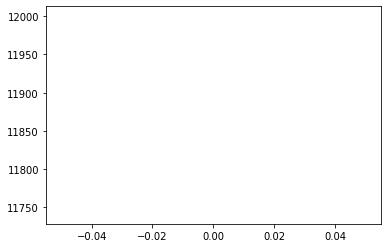

In [0]:
import pylab as pl
pl.plot(times, forecasts, 'r')
pl.plot(times, labels[:,-1], 'b')
# pl.plot(x,y,'*k')
pl.show()
